In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

In [12]:
# Load data
df = pd.read_csv('/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Performance_model_betas_new.csv')

# Renaming terms clearly for plotting
rename_dict = {
    '(Intercept)': 'Intercept',
    'Dwelling_Time_Building_Gaze_z': 'Dwell time Building',
    'Dwelling_Time_Agent_Gaze_z': 'Dwell time agent',
    'ContextEffectfPublic': 'Building (Residential vs. Public)',
    'Agent_TypefCongruent': 'Acontextual Vs. Congruent',
    'Agent_TypefIncongruent': 'Acontextual Vs. Incongruent',
    'GTE_median_adj': 'Median GTE'
}

# Correctly overwrite the 'Predictor' column
df['Predictor'] = df['Predictor'].replace(rename_dict)

# Sort according to your desired factor order
factor_order = [
    'Dwell time Building', 
    'Dwell time agent',
    'Building (Residential vs. Public)',
    'Acontextual Vs. Congruent',
    'Acontextual Vs. Incongruent',
    'Median GTE',
    'Intercept'
][::-1]

# Now indexing works correctly
df = df.set_index('Predictor').loc[factor_order].reset_index()

# Add annotation column
df["Anotate"] = df["Estimate"].round(2).astype(str)


In [11]:
df.head(10)

,Predictor,Estimate,CI_lower,CI_upper
0,Intercept,4.061726,3.913672,4.206466
1,Acontextual Vs. Congruent,0.002905,-0.058145,0.065377
2,Acontextual Vs. Incongruent,-0.122576,-0.171707,-0.073250
3,Building (Residential vs. Public),-0.089274,-0.138106,-0.040635
4,GTE_median_adj,-0.312568,-0.477630,-0.145266
5,Dwelling_Time_Agent_Gaze_z,-0.019301,-0.038945,0.000427
6,Dwelling_Time_Building_Gaze_z,-0.046558,-0.062658,-0.030481


In [3]:
df.head()

,Predictor,Estimate,CI_lower,CI_upper,Anotate
0,Intercept,4.021912,3.865372,4.177064,4.02
1,Median GTE,-0.311208,-0.485464,-0.137978,-0.31
2,Acontextual Vs. Incongruent,-0.163101,-0.240942,-0.086617,-0.16
3,Acontextual Vs. Congruent,0.086189,-0.004626,0.177391,0.09
4,Building (Residential vs. Public),-0.089577,-0.140041,-0.039438,-0.09


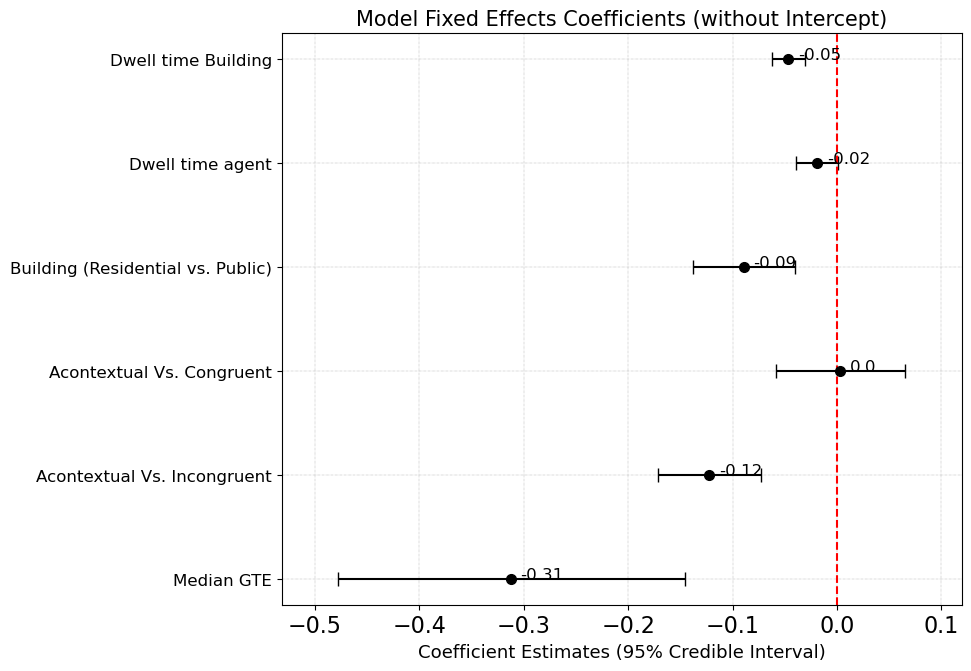

In [13]:
# Filter out the intercept before plotting
df_no_intercept = df[df["Predictor"] != "Intercept"].reset_index(drop=True)

# Recompute y-axis positions after filtering
y_positions = np.arange(len(df_no_intercept))

# Create figure
fig, ax = plt.subplots(figsize=(10, 7))

# Plot with error bars
ax.errorbar(
    x=df_no_intercept["Estimate"], 
    y=y_positions, 
    xerr=[df_no_intercept["Estimate"] - df_no_intercept["CI_lower"], df_no_intercept["CI_upper"] - df_no_intercept["Estimate"]],
    fmt='o',
    color='black',
    markersize=7,
    capsize=5
)

# Annotate points
for xi, yi, annotation in zip(df_no_intercept["Estimate"], y_positions, df_no_intercept["Anotate"]):
    ax.annotate(annotation, (xi, yi), textcoords="offset points",
                xytext=(7, 0), ha='left', fontsize=12)

# Reference line at zero
ax.axvline(x=0, color='red', linestyle='--')

# Customize grid
ax.grid(True, linestyle='-.', linewidth=0.3)

# Set y-ticks to factor names
ax.set_yticks(y_positions)
ax.set_yticklabels(df_no_intercept["Predictor"], fontsize=12)

# Set labels and title
ax.set_xlabel("Coefficient Estimates (95% Credible Interval)", fontsize=13)
ax.set_title("Model Fixed Effects Coefficients (without Intercept)", fontsize=15)

# Adjust x-axis limits
x_margin = (df_no_intercept["CI_upper"].max() - df_no_intercept["CI_lower"].min()) * 0.1
ax.set_xlim(df_no_intercept["CI_lower"].min() - x_margin, df_no_intercept["CI_upper"].max() + x_margin)

# Tight layout
plt.tight_layout()

# Save plot as JPG
plt.savefig("Python_Model_Coefficients_no_intercept.jpg", dpi=300, bbox_inches="tight", format='jpg')

# Display plot
plt.show()


In [14]:
# Calculate percentage changes
df_no_intercept['Percent_change'] = (np.exp(df_no_intercept['Estimate']) - 1) * 100
df_no_intercept['Percent_lower'] = (np.exp(df_no_intercept['CI_lower']) - 1) * 100
df_no_intercept['Percent_upper'] = (np.exp(df_no_intercept['CI_upper']) - 1) * 100

# Annotation labels
df_no_intercept["Percent_annotate"] = df_no_intercept["Percent_change"].round(1).astype(str) + '%'

# Sort by percentage change for bar plot clarity
df_sorted = df_no_intercept.sort_values(by='Percent_change', ascending=False).reset_index(drop=True)


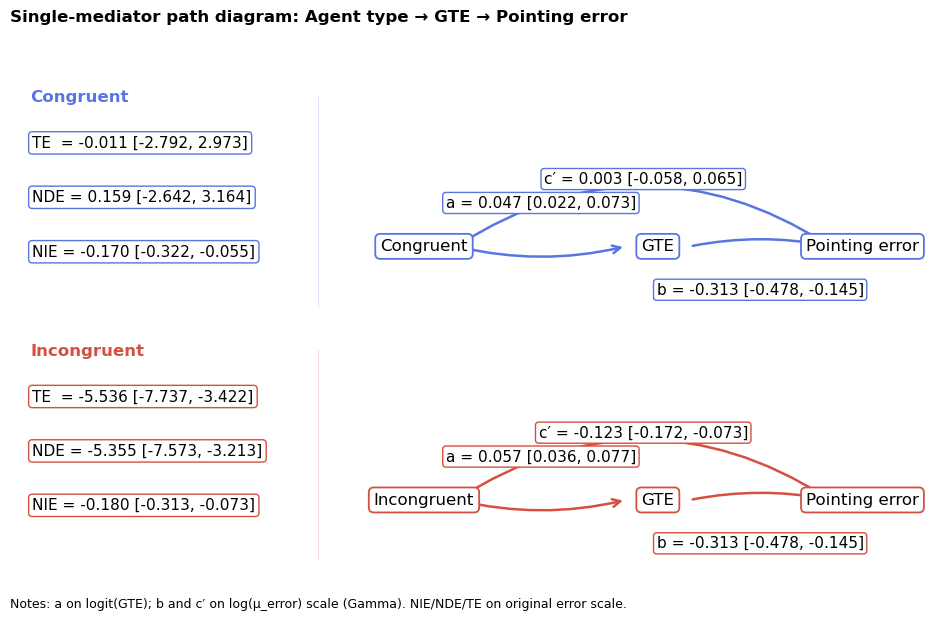

In [42]:
# JUPYTER CELL: Path diagram from med_summary.csv (split left metrics / right paths)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pathlib import Path

# ---------- SETTINGS ----------
MED_SUMMARY_CSV = Path("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/med_summary.csv")
PATH_LABELS_CSV = Path("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/path_labels.csv")  # optional
ORDER = ["Congruent", "Incongruent"]

# ---------- COLORS ----------
copper_palette = mpl.colormaps.get_cmap("copper").resampled(20)
orange_from_copper = copper_palette(15)
coolwarm_palette = sns.color_palette("coolwarm", 20)
custom_palette = {
    "Acontextual": orange_from_copper,
    "Congruent":   coolwarm_palette[1],
    "Incongruent": coolwarm_palette[18],
}

# ---------- LOAD ----------
med = pd.read_csv(MED_SUMMARY_CSV)

def pick(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"Missing any of {candidates}. Found: {df.columns.tolist()}")

contrast_col = pick(med, ["Contrast"])
nie_col      = pick(med, ["NIE_95","NIE 95%"])
nde_col      = pick(med, ["NDE_95","NDE 95%"])
te_col       = pick(med, ["TE_95","TE 95%"])

med_rows = med[[contrast_col, nie_col, nde_col, te_col]].copy()
med_rows.columns = ["Contrast","NIE","NDE","TE"]

if ORDER:
    med_rows["__ord__"] = med_rows["Contrast"].apply(lambda x: ORDER.index(x) if x in ORDER else 999)
    med_rows = med_rows.sort_values("__ord__").drop(columns="__ord__")

# Optional path labels (a, b, c′)
labels = {c: {"a_label":"a = (provide)", "b_label":"b = (provide)", "cprime_label":"c′ = (provide)"}
          for c in med_rows["Contrast"]}

if PATH_LABELS_CSV.exists():
    lab_df = pd.read_csv(PATH_LABELS_CSV)
    for _, r in lab_df.iterrows():
        c = r.get("Contrast")
        if isinstance(c, str) and c in labels:
            labels[c] = {
                "a_label": r.get("a_label", labels[c]["a_label"]),
                "b_label": r.get("b_label", labels[c]["b_label"]),
                "cprime_label": r.get("cprime_label", labels[c]["cprime_label"]),
            }

# ---------- DRAW HELPER (split panel) ----------
def _draw_panel_split(ax, contrast, a_label, b_label, cprime_label, metrics, color):
    """
    Split-panel med diagram with:
      - left metrics (TE/NDE/NIE)
      - right path diagram (a, b, c′)
    Arrows never enter node boxes; labels don't touch lines. Labels are centered on paths.
    """
    ax.set_axis_off()

    # ---- panel layout
    left_ax  = ax.inset_axes([0.00, 0.05, 0.30, 0.90])   # metrics
    right_ax = ax.inset_axes([0.35, 0.05, 0.65, 0.90])   # paths

    # ---- styles
    fs_metrics = 11
    fs_nodes   = 12
    fs_labels  = 11

    node_kw = dict(boxstyle="round,pad=0.30", fc="white", ec=color, lw=1.3)
    lbl_kw  = dict(boxstyle="round,pad=0.20", fc="white", ec=color, lw=1.0)
    box_kw  = dict(boxstyle="round,pad=0.24", fc="white", ec=color, lw=1.0)

    # =========================
    # LEFT: metrics
    # =========================
    left_ax.set_xlim(0, 1); left_ax.set_ylim(0, 1); left_ax.axis('off')
    y_top, step = 0.78, 0.26
    left_ax.text(0.04, y_top,            f"TE  = {metrics['TE']}",  ha="left", va="center", fontsize=fs_metrics, bbox=box_kw, zorder=3)
    left_ax.text(0.04, y_top - step,     f"NDE = {metrics['NDE']}", ha="left", va="center", fontsize=fs_metrics, bbox=box_kw, zorder=3)
    left_ax.text(0.04, y_top - 2*step,   f"NIE = {metrics['NIE']}", ha="left", va="center", fontsize=fs_metrics, bbox=box_kw, zorder=3)

    # divider
    ax.plot([0.33, 0.33], [0.05, 0.95], transform=ax.transAxes, color=color, lw=0.6, alpha=0.25)

    # =========================
    # RIGHT: paths
    # =========================
    right_ax.set_xlim(0, 4.0)
    right_ax.set_ylim(0.6, 2.0)
    right_ax.axis('off')

    # node x-positions and a small hard margin so arrows don't touch boxes
    x_contrast, x_gte, x_error = 0.6, 2.2, 3.6
    dx = 0.22   # margin from each node center along x

    # nodes (draw above arrows)
    right_ax.text(x_contrast, 1.00, contrast,          ha='center', va='center', fontsize=fs_nodes, bbox=node_kw, zorder=3)
    right_ax.text(x_gte,      1.00, "GTE",             ha='center', va='center', fontsize=fs_nodes, bbox=node_kw, zorder=3)
    right_ax.text(x_error,    1.00, "Pointing error",  ha='center', va='center', fontsize=fs_nodes, bbox=node_kw, zorder=3)

    # --- arrow endpoints (keep off boxes)
    x0_a, x1_a = x_contrast + dx, x_gte   - dx   # contrast → GTE
    x0_b, x1_b = x_gte      + dx, x_error - dx   # GTE → error
    x0_c, x1_c = x_contrast + dx, x_error - dx   # contrast → error

    # ---- a: slight upward curve
    rad_a = +0.12
    right_ax.annotate("", xy=(x1_a, 1.00), xytext=(x0_a, 1.00),
                      arrowprops=dict(arrowstyle="->", lw=1.8, color=color,
                                      connectionstyle=f"arc3,rad={rad_a}"),
                      zorder=2, clip_on=False)
    xm_a = 0.5*(x0_a + x1_a); ya = 1.24
    right_ax.text(xm_a, ya, a_label, ha="center", va="bottom",
                  fontsize=fs_labels, bbox=lbl_kw, zorder=3)

    # ---- b: slight downward curve
    rad_b = -0.10
    right_ax.annotate("", xy=(x1_b, 1.00), xytext=(x0_b, 1.00),
                      arrowprops=dict(arrowstyle="->", lw=1.8, color=color,
                                      connectionstyle=f"arc3,rad={rad_b}"),
                      zorder=2, clip_on=False)
    xm_b = 0.5*(x0_b + x1_b); yb = 0.76
    right_ax.text(xm_b, yb, b_label, ha="center", va="top",
                  fontsize=fs_labels, bbox=lbl_kw, zorder=3)

    # ---- c′: large arc above
    rad_c = -0.32
    right_ax.annotate("", xy=(x1_c, 1.00), xytext=(x0_c, 1.00),
                      arrowprops=dict(arrowstyle="->", lw=1.8, color=color,
                                      connectionstyle=f"arc3,rad={rad_c}"),
                      zorder=2, clip_on=False)
    xm_c = 0.5*(x0_c + x1_c); yc = 1.40
    right_ax.text(xm_c, yc, cprime_label, ha="center", va="bottom",
                  fontsize=fs_labels, bbox=lbl_kw, zorder=3)

# ---------- PLOT ----------
n = len(med_rows)
if n == 0:
    raise ValueError("med_summary.csv has no rows to plot.")

# single, wider creation of fig/axes
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(9.5, 3.1*n))
if n == 1:
    axes = [axes]

fig.suptitle("Single-mediator path diagram: Agent type → GTE → Pointing error",
             x=0.01, ha="left", fontsize=12, fontweight="bold")
caption = ("Notes: a on logit(GTE); b and c′ on log(μ_error) scale (Gamma). "
           "NIE/NDE/TE on original error scale.")
fig.text(0.01, 0.01, caption, ha="left", va="bottom", fontsize=9)

for ax, (_, row) in zip(axes, med_rows.iterrows()):
    contrast = row["Contrast"]
    color = custom_palette.get(contrast, "black")
    metrics = {"TE": row["TE"], "NDE": row["NDE"], "NIE": row["NIE"]}

    _draw_panel_split(
        ax,
        contrast=contrast,
        a_label=labels[contrast]["a_label"],
        b_label=labels[contrast]["b_label"],
        cprime_label=labels[contrast]["cprime_label"],
        metrics=metrics,
        color=color
    )

    ax.text(0.01, 0.98, contrast, transform=ax.transAxes,
            ha="left", va="top", fontsize=12, fontweight="bold", color=color)

fig.tight_layout(rect=[0, 0.04, 1, 0.95])
plt.show()

# Save
fig.savefig("mediation_path_diagram_vertical.png", dpi=300, bbox_inches="tight")
fig.savefig("mediation_path_diagram_vertical.svg", bbox_inches="tight")


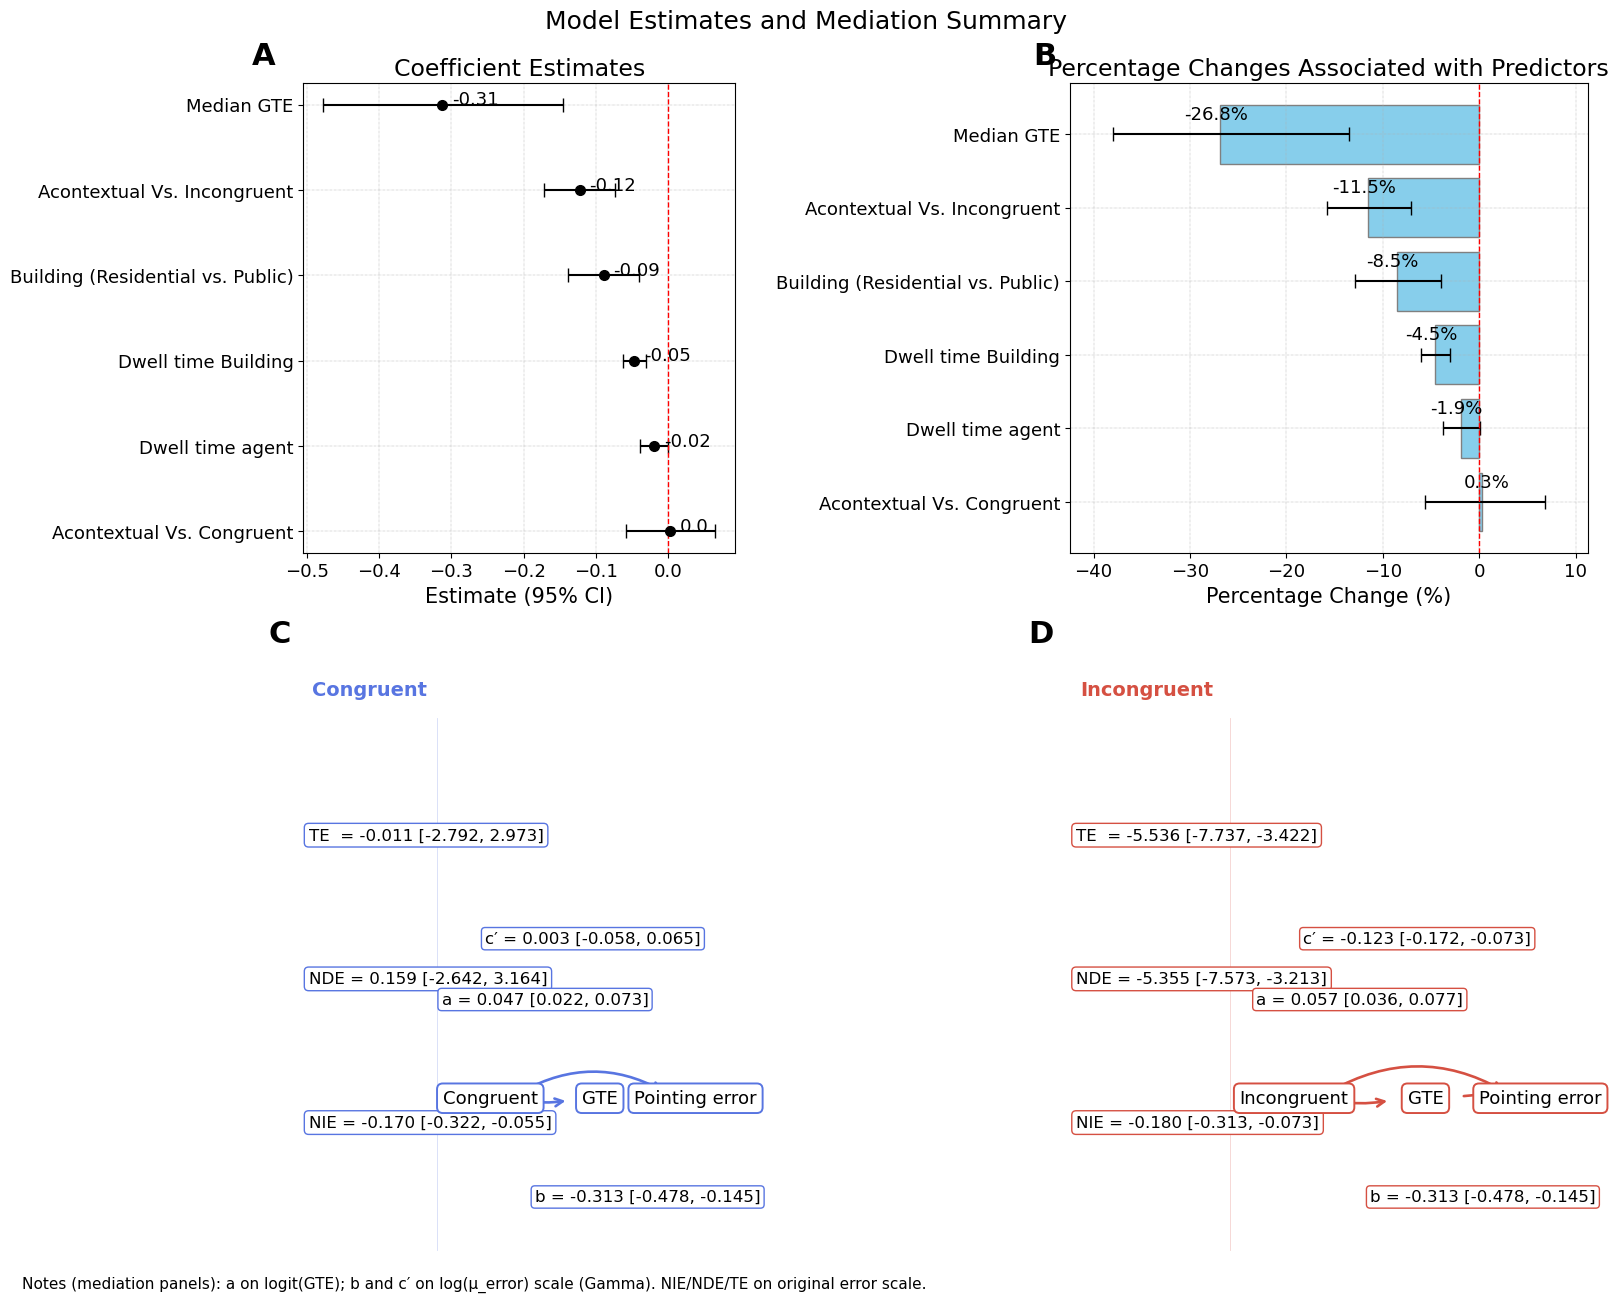

In [46]:
# ========= FINAL 2×2 (robust layout) =========
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})

# ---------- safer path panel ----------
def _draw_panel_split(ax, contrast, a_label, b_label, cprime_label, metrics, color):
    ax.set_axis_off()

    # split: left metrics, right paths
    left_ax  = ax.inset_axes([0.00, 0.08, 0.30, 0.84])
    right_ax = ax.inset_axes([0.33, 0.08, 0.65, 0.84])

    fs_metrics = 12
    fs_nodes   = 13
    fs_labels  = 12

    node_kw = dict(boxstyle="round,pad=0.32", fc="white", ec=color, lw=1.4)
    lbl_kw  = dict(boxstyle="round,pad=0.22", fc="white", ec=color, lw=1.0)
    box_kw  = dict(boxstyle="round,pad=0.26", fc="white", ec=color, lw=1.0)

    # Left metric boxes
    left_ax.set_xlim(0, 1); left_ax.set_ylim(0, 1); left_ax.axis('off')
    y0, step = 0.78, 0.27
    left_ax.text(0.04, y0,           f"TE  = {metrics['TE']}",  ha="left", va="center", fontsize=fs_metrics, bbox=box_kw, zorder=3)
    left_ax.text(0.04, y0-step,      f"NDE = {metrics['NDE']}", ha="left", va="center", fontsize=fs_metrics, bbox=box_kw, zorder=3)
    left_ax.text(0.04, y0-2*step,    f"NIE = {metrics['NIE']}", ha="left", va="center", fontsize=fs_metrics, bbox=box_kw, zorder=3)

    # Vertical separator
    ax.plot([0.31, 0.31], [0.08, 0.92], transform=ax.transAxes, color=color, lw=0.6, alpha=0.25)

    # Right path diagram
    right_ax.set_xlim(0, 4.1); right_ax.set_ylim(0.6, 2.0); right_ax.axis('off')

    # node centers + hard x-margins so arrows never enter boxes
    x_contrast, x_gte, x_error = 0.65, 2.25, 3.65
    dx = 0.30  # increase if any arrow still touches a box

    # nodes (draw above arrows)
    right_ax.text(x_contrast, 1.00, contrast,         ha='center', va='center', fontsize=fs_nodes, bbox=node_kw, zorder=3)
    right_ax.text(x_gte,      1.00, "GTE",            ha='center', va='center', fontsize=fs_nodes, bbox=node_kw, zorder=3)
    right_ax.text(x_error,    1.00, "Pointing error", ha='center', va='center', fontsize=fs_nodes, bbox=node_kw, zorder=3)

    # helper: weighted midpoint for label centering
    def mid(x0, x1, bias=0.5):
        return x0*(1-bias) + x1*bias

    # common arrowprops with shrink to keep tips off boxes
    ap = dict(arrowstyle="->", lw=1.9, color=color, shrinkA=10, shrinkB=10)

    # a: contrast → GTE
    right_ax.annotate("", xy=(x_gte - dx, 1.00), xytext=(x_contrast + dx, 1.00),
                      arrowprops={**ap, "connectionstyle":"arc3,rad=0.12"}, zorder=2, clip_on=False)
    right_ax.text(mid(x_contrast+dx, x_gte-dx, 0.50), 1.24, a_label,
                  ha="center", va="bottom", fontsize=fs_labels, bbox=lbl_kw, zorder=3)

    # b: GTE → Pointing error
    right_ax.annotate("", xy=(x_error - dx, 1.00), xytext=(x_gte + dx, 1.00),
                      arrowprops={**ap, "connectionstyle":"arc3,rad=-0.10"}, zorder=2, clip_on=False)
    right_ax.text(mid(x_gte+dx, x_error-dx, 0.50), 0.76, b_label,
                  ha="center", va="top", fontsize=fs_labels, bbox=lbl_kw, zorder=3)

    # c′: contrast → Pointing error (big arc)
    right_ax.annotate("", xy=(x_error - dx, 1.00), xytext=(x_contrast + dx, 1.00),
                      arrowprops={**ap, "connectionstyle":"arc3,rad=-0.32"}, zorder=2, clip_on=False)
    right_ax.text(mid(x_contrast+dx, x_error-dx, 0.50), 1.40, cprime_label,
                  ha="center", va="bottom", fontsize=fs_labels, bbox=lbl_kw, zorder=3)

# ---------- prepare top-left data (sorted like df_sorted) ----------
df_no_intercept_sorted = (
    df_no_intercept
    .set_index('Predictor')
    .loc[df_sorted['Predictor']]
    .reset_index()
)

# ---------- figure ----------
fig, axes = plt.subplots(
    2, 2, figsize=(16, 13),
    gridspec_kw={'width_ratios': [1, 1.2], 'height_ratios': [1.0, 1.35]},
    constrained_layout=True  # robust spacing
)
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

# ---- A) Coefficient estimates ----
yL = np.arange(len(df_no_intercept_sorted))
ax1.errorbar(
    x=df_no_intercept_sorted["Estimate"], y=yL,
    xerr=[df_no_intercept_sorted["Estimate"] - df_no_intercept_sorted["CI_lower"],
          df_no_intercept_sorted["CI_upper"] - df_no_intercept_sorted["Estimate"]],
    fmt='o', color='black', markersize=7, capsize=5
)
for xi, yi, ann in zip(df_no_intercept_sorted["Estimate"], yL, df_no_intercept_sorted["Anotate"]):
    ax1.annotate(ann, (xi, yi), xytext=(7, 0), textcoords='offset points', fontsize=13)
ax1.axvline(0, color='red', linestyle='--', lw=1)
ax1.grid(True, linestyle='-.', lw=0.3)
ax1.set_yticks(yL)
ax1.set_yticklabels(df_no_intercept_sorted["Predictor"], fontsize=14)
ax1.set_xlabel("Estimate (95% CI)", fontsize=15)
ax1.set_title("Coefficient Estimates", fontsize=17)
ax1.tick_params(axis='both', labelsize=13)

# ---- B) Percent changes ----
yR = np.arange(len(df_sorted))
ax2.barh(
    y=yR, width=df_sorted["Percent_change"],
    xerr=[df_sorted["Percent_change"] - df_sorted["Percent_lower"],
          df_sorted["Percent_upper"] - df_sorted["Percent_change"]],
    color='skyblue', edgecolor='gray', capsize=5
)
for xi, yi, ann in zip(df_sorted["Percent_change"], yR, df_sorted["Percent_annotate"]):
    ax2.annotate(ann, (xi, yi),
                 xytext=(3 if xi >= 0 else -3, 8),
                 textcoords='offset points', fontsize=13,
                 ha='center', va='bottom')
ax2.axvline(0, color='red', linestyle='--', lw=1)
ax2.grid(True, linestyle='-.', lw=0.3)
ax2.set_yticks(yR)
ax2.set_yticklabels(df_sorted["Predictor"], fontsize=14)
ax2.set_xlabel("Percentage Change (%)", fontsize=15)
ax2.set_title("Percentage Changes Associated with Predictors", fontsize=17)
ax2.tick_params(axis='both', labelsize=13)
x_margin = (df_sorted["Percent_upper"].max() - df_sorted["Percent_lower"].min()) * 0.10
ax2.set_xlim(df_sorted["Percent_lower"].min() - x_margin,
             df_sorted["Percent_upper"].max() + x_margin)

# ---- Helpers for bottom panels ----
def _metrics(contrast):
    r = med_rows.loc[med_rows["Contrast"] == contrast].iloc[0]
    return {"TE": r["TE"], "NDE": r["NDE"], "NIE": r["NIE"]}

# ---- C) Congruent ----
c = "Congruent"
_draw_panel_split(
    ax3, contrast=c,
    a_label=labels[c]["a_label"], b_label=labels[c]["b_label"], cprime_label=labels[c]["cprime_label"],
    metrics=_metrics(c), color=custom_palette.get(c, "black")
)
ax3.text(-0.08, 1.04, "C", transform=ax3.transAxes, fontsize=22, fontweight="bold")  # letter INSIDE axes
ax3.text(0.02, 0.98, c, transform=ax3.transAxes, ha="left", va="top",
         fontsize=14, fontweight="bold", color=custom_palette.get(c, "black"))

# ---- D) Incongruent ----
c = "Incongruent"
_draw_panel_split(
    ax4, contrast=c,
    a_label=labels[c]["a_label"], b_label=labels[c]["b_label"], cprime_label=labels[c]["cprime_label"],
    metrics=_metrics(c), color=custom_palette.get(c, "black")
)
ax4.text(-0.08, 1.04, "D", transform=ax4.transAxes, fontsize=22, fontweight="bold")
ax4.text(0.02, 0.98, c, transform=ax4.transAxes, ha="left", va="top",
         fontsize=14, fontweight="bold", color=custom_palette.get(c, "black"))

# Put A and B letters inside their axes too
ax1.text(-0.12, 1.04, "A", transform=ax1.transAxes, fontsize=22, fontweight="bold")
ax2.text(-0.07, 1.04, "B", transform=ax2.transAxes, fontsize=22, fontweight="bold")

# Suptitle (safe; constrained_layout handles space)
fig.suptitle("Model Estimates and Mediation Summary", fontsize=18)

# Bottom caption
fig.text(0.01, 0.01,
         "Notes (mediation panels): a on logit(GTE); b and c′ on log(μ_error) scale (Gamma). "
         "NIE/NDE/TE on original error scale.",
         ha='left', va='bottom', fontsize=11)

# Save + show
fig.savefig("Combined_Estimates_PercentChanges_Mediation_2x2.png", dpi=300, bbox_inches="tight")
fig.savefig("Combined_Estimates_PercentChanges_Mediation_2x2.svg", bbox_inches="tight")
plt.show()


In [22]:
# Add near the top of your Jupyter cell:
import matplotlib as mpl
import seaborn as sns


def cmap_resampled(name, n):
    try:
        return mpl.colormaps.get_cmap(name).resampled(n)  # new API
    except AttributeError:
        import matplotlib.cm as oldcm
        return oldcm.get_cmap(name, n)                    # fallback


copper_palette = cmap_resampled("copper", 20)
orange_from_copper = copper_palette(15)

# coolwarm via seaborn (list of RGB tuples)
coolwarm_palette = sns.color_palette("coolwarm", n_colors=20)

custom_palette = {
    "Acontextual": orange_from_copper,
    "Congruent":   coolwarm_palette[1],
    "Incongruent": coolwarm_palette[18],
}




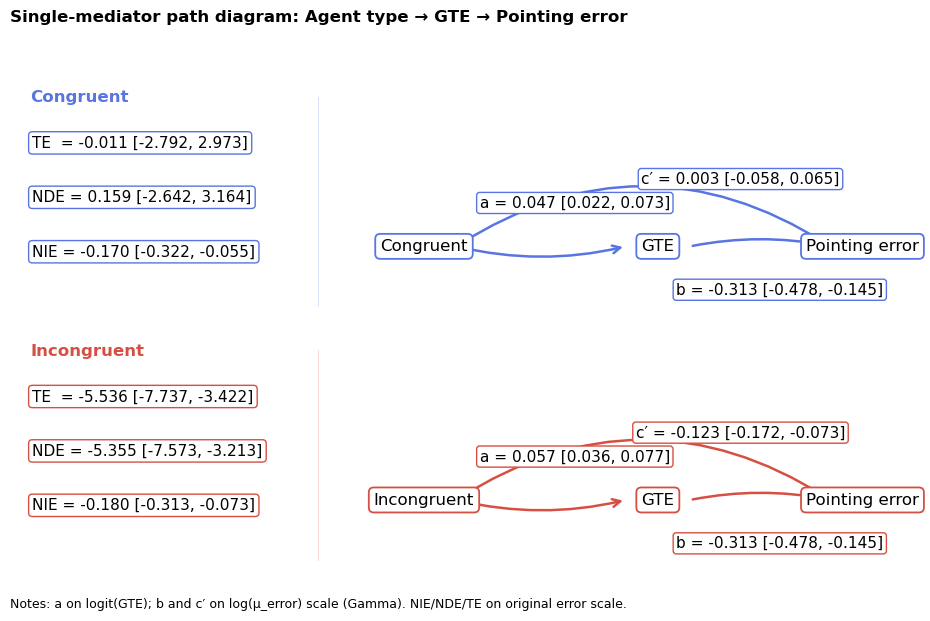

In [41]:
# JUPYTER CELL: Path diagram from med_summary.csv (split left metrics / right paths)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pathlib import Path

# ---------- SETTINGS ----------
MED_SUMMARY_CSV = Path("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/med_summary.csv")
PATH_LABELS_CSV = Path("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/path_labels.csv")  # optional
ORDER = ["Congruent", "Incongruent"]

# ---------- COLORS ----------
copper_palette = mpl.colormaps.get_cmap("copper").resampled(20)
orange_from_copper = copper_palette(15)
coolwarm_palette = sns.color_palette("coolwarm", 20)
custom_palette = {
    "Acontextual": orange_from_copper,
    "Congruent":   coolwarm_palette[1],
    "Incongruent": coolwarm_palette[18],
}

# ---------- LOAD ----------
med = pd.read_csv(MED_SUMMARY_CSV)

def pick(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"Missing any of {candidates}. Found: {df.columns.tolist()}")

contrast_col = pick(med, ["Contrast"])
nie_col      = pick(med, ["NIE_95","NIE 95%"])
nde_col      = pick(med, ["NDE_95","NDE 95%"])
te_col       = pick(med, ["TE_95","TE 95%"])

med_rows = med[[contrast_col, nie_col, nde_col, te_col]].copy()
med_rows.columns = ["Contrast","NIE","NDE","TE"]

if ORDER:
    med_rows["__ord__"] = med_rows["Contrast"].apply(lambda x: ORDER.index(x) if x in ORDER else 999)
    med_rows = med_rows.sort_values("__ord__").drop(columns="__ord__")

# Optional path labels (a, b, c′)
labels = {c: {"a_label":"a = (provide)", "b_label":"b = (provide)", "cprime_label":"c′ = (provide)"}
          for c in med_rows["Contrast"]}

if PATH_LABELS_CSV.exists():
    lab_df = pd.read_csv(PATH_LABELS_CSV)
    for _, r in lab_df.iterrows():
        c = r.get("Contrast")
        if isinstance(c, str) and c in labels:
            labels[c] = {
                "a_label": r.get("a_label", labels[c]["a_label"]),
                "b_label": r.get("b_label", labels[c]["b_label"]),
                "cprime_label": r.get("cprime_label", labels[c]["cprime_label"]),
            }

# ---------- DRAW HELPER (split panel) ----------
def _draw_panel_split(ax, contrast, a_label, b_label, cprime_label, metrics, color):
    """
    Split-panel med diagram with:
      - left metrics (TE/NDE/NIE)
      - right path diagram (a, b, c′)
    Arrows never enter node boxes; labels don't touch lines.
    """
    ax.set_axis_off()

    # ---- panel layout
    left_ax  = ax.inset_axes([0.00, 0.05, 0.30, 0.90])   # metrics
    right_ax = ax.inset_axes([0.35, 0.05, 0.65, 0.90])   # paths

    # ---- styles
    fs_metrics = 11
    fs_nodes   = 12
    fs_labels  = 11

    node_kw = dict(boxstyle="round,pad=0.30", fc="white", ec=color, lw=1.3)
    lbl_kw  = dict(boxstyle="round,pad=0.20", fc="white", ec=color, lw=1.0)
    box_kw  = dict(boxstyle="round,pad=0.24", fc="white", ec=color, lw=1.0)

    # =========================
    # LEFT: metrics
    # =========================
    left_ax.set_xlim(0, 1); left_ax.set_ylim(0, 1); left_ax.axis('off')
    y_top, step = 0.78, 0.26
    left_ax.text(0.04, y_top,            f"TE  = {metrics['TE']}",  ha="left", va="center", fontsize=fs_metrics, bbox=box_kw, zorder=3)
    left_ax.text(0.04, y_top - step,     f"NDE = {metrics['NDE']}", ha="left", va="center", fontsize=fs_metrics, bbox=box_kw, zorder=3)
    left_ax.text(0.04, y_top - 2*step,   f"NIE = {metrics['NIE']}", ha="left", va="center", fontsize=fs_metrics, bbox=box_kw, zorder=3)

    # divider
    ax.plot([0.33, 0.33], [0.05, 0.95], transform=ax.transAxes, color=color, lw=0.6, alpha=0.25)

    # =========================
    # RIGHT: paths
    # =========================
    right_ax.set_xlim(0, 4.0)
    right_ax.set_ylim(0.6, 2.0)
    right_ax.axis('off')

    # node x-positions and a small hard margin so arrows don't touch boxes
    x_contrast, x_gte, x_error = 0.6, 2.2, 3.6
    dx = 0.22   # margin from each node center along x

    # nodes (draw above arrows)
    right_ax.text(x_contrast, 1.00, contrast,          ha='center', va='center', fontsize=fs_nodes, bbox=node_kw, zorder=3)
    right_ax.text(x_gte,      1.00, "GTE",             ha='center', va='center', fontsize=fs_nodes, bbox=node_kw, zorder=3)
    right_ax.text(x_error,    1.00, "Pointing error",  ha='center', va='center', fontsize=fs_nodes, bbox=node_kw, zorder=3)

    # helper: right-biased midpoint for label placement
    def rb_mid(x0, x1, bias=0.70):  # >0.5 pushes toward x1
        return x0*(1-bias) + x1*bias

    # ---- a: contrast → GTE (slight upward curve)
    right_ax.annotate(
        "", xy=(x_gte - dx, 1.00), xytext=(x_contrast + dx, 1.00),
        arrowprops=dict(arrowstyle="->", lw=1.8, color=color,
                        connectionstyle="arc3,rad=0.12"), zorder=2, clip_on=False
    )
    right_ax.text(rb_mid(x_contrast+dx, x_gte-dx, 0.70), 1.24, a_label,
                  ha="center", va="bottom", fontsize=fs_labels, bbox=lbl_kw, zorder=3)

    # ---- b: GTE → Pointing error (slight downward curve)
    right_ax.annotate(
        "", xy=(x_error - dx, 1.00), xytext=(x_gte + dx, 1.00),
        arrowprops=dict(arrowstyle="->", lw=1.8, color=color,
                        connectionstyle="arc3,rad=-0.10"), zorder=2, clip_on=False
    )
    right_ax.text(rb_mid(x_gte+dx, x_error-dx, 0.64), 0.76, b_label,
                  ha="center", va="top", fontsize=fs_labels, bbox=lbl_kw, zorder=3)

    # ---- c′: contrast → Pointing error (large arc above)
    right_ax.annotate(
        "", xy=(x_error - dx, 1.00), xytext=(x_contrast + dx, 1.00),
        arrowprops=dict(arrowstyle="->", lw=1.8, color=color,
                        connectionstyle="arc3,rad=-0.32"), zorder=2, clip_on=False
    )
    right_ax.text(rb_mid(x_contrast+dx, x_error-dx, 0.76), 1.40, cprime_label,
                  ha="center", va="bottom", fontsize=fs_labels, bbox=lbl_kw, zorder=3)

# ---------- PLOT ----------
n = len(med_rows)
if n == 0:
    raise ValueError("med_summary.csv has no rows to plot.")

# single, wider creation of fig/axes
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(9.5, 3.1*n))
if n == 1:
    axes = [axes]

fig.suptitle("Single-mediator path diagram: Agent type → GTE → Pointing error",
             x=0.01, ha="left", fontsize=12, fontweight="bold")
caption = ("Notes: a on logit(GTE); b and c′ on log(μ_error) scale (Gamma). "
           "NIE/NDE/TE on original error scale.")
fig.text(0.01, 0.01, caption, ha="left", va="bottom", fontsize=9)

for ax, (_, row) in zip(axes, med_rows.iterrows()):
    contrast = row["Contrast"]
    color = custom_palette.get(contrast, "black")
    metrics = {"TE": row["TE"], "NDE": row["NDE"], "NIE": row["NIE"]}

    _draw_panel_split(
        ax,
        contrast=contrast,
        a_label=labels[contrast]["a_label"],
        b_label=labels[contrast]["b_label"],
        cprime_label=labels[contrast]["cprime_label"],
        metrics=metrics,
        color=color
    )

    ax.text(0.01, 0.98, contrast, transform=ax.transAxes,
            ha="left", va="top", fontsize=12, fontweight="bold", color=color)

fig.tight_layout(rect=[0, 0.04, 1, 0.95])
plt.show()

# Save
fig.savefig("mediation_path_diagram_vertical.png", dpi=300, bbox_inches="tight")
fig.savefig("mediation_path_diagram_vertical.svg", bbox_inches="tight")


/var/folders/wj/11sgsjxd7x75l9tkc6r2l1p80000gn/T/ipykernel_30300/2458288386.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  bone_r = cm.get_cmap('bone_r')


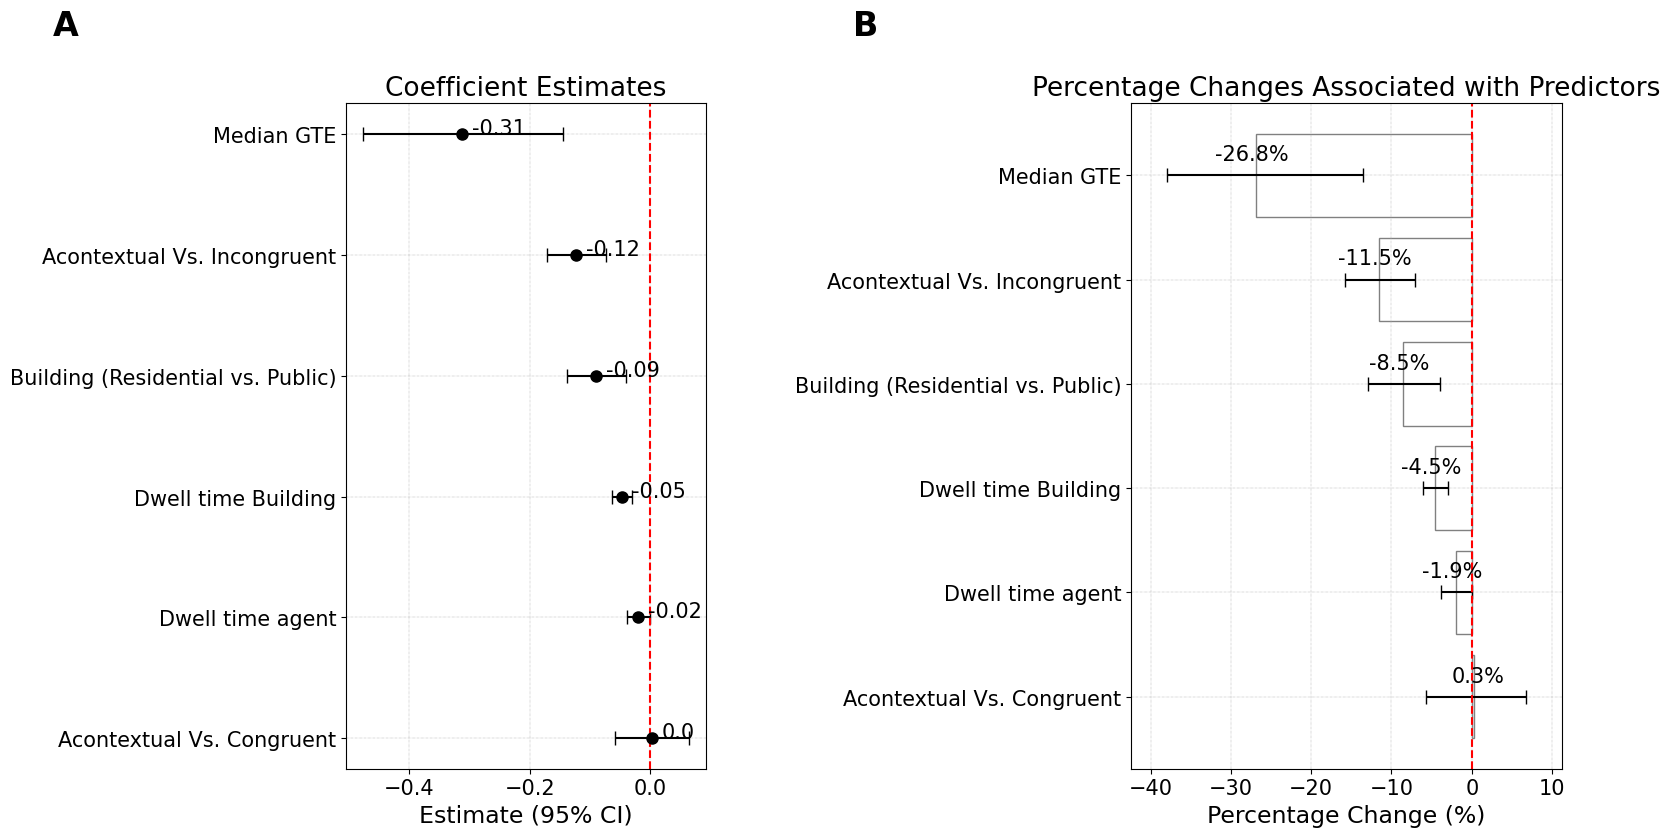

In [47]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Optional: Global font size update (make fonts bigger)
plt.rcParams.update({'font.size': 16})  # slightly larger than your previous 14

# Get first color from bone_r palette
bone_r = cm.get_cmap('bone_r')
bar_color = bone_r(0)  # gets the first color (darkest one)

# === LEFT PLOT stays the same but with slightly larger fonts ===
# Sort df_no_intercept to match df_sorted exactly
df_no_intercept_sorted = df_no_intercept.set_index('Predictor').loc[df_sorted['Predictor']].reset_index()

# Define figure layout: two side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 1.2]})

# LEFT PLOT: Coefficient Estimates (now sorted!)
y_positions_left = np.arange(len(df_no_intercept_sorted))

ax1.errorbar(
    x=df_no_intercept_sorted["Estimate"], 
    y=y_positions_left,
    xerr=[df_no_intercept_sorted["Estimate"] - df_no_intercept_sorted["CI_lower"],
          df_no_intercept_sorted["CI_upper"] - df_no_intercept_sorted["Estimate"]],
    fmt='o',
    color='black',
    markersize=8,
    capsize=5
)

# Annotate left plot
for xi, yi, annotation in zip(df_no_intercept_sorted["Estimate"], y_positions_left, df_no_intercept_sorted["Anotate"]):
    ax1.annotate(annotation, (xi, yi), xytext=(7, 0), textcoords='offset points', fontsize=15)

ax1.axvline(x=0, color='red', linestyle='--')
ax1.grid(True, linestyle='-.', linewidth=0.3)
ax1.set_yticks(y_positions_left)
ax1.set_yticklabels(df_no_intercept_sorted["Predictor"], fontsize=15)
ax1.set_xlabel("Estimate (95% CI)", fontsize=17)
ax1.set_title("Coefficient Estimates", fontsize=19)
ax1.tick_params(axis='both', labelsize=15)

# === RIGHT PLOT: Percentage Changes (with bone_r color) ===
y_positions_right = np.arange(len(df_sorted))

ax2.barh(
    y=y_positions_right, 
    width=df_sorted["Percent_change"],
    xerr=[df_sorted["Percent_change"] - df_sorted["Percent_lower"],
          df_sorted["Percent_upper"] - df_sorted["Percent_change"]],
    color=bar_color,
    edgecolor='gray',
    capsize=5
)

# Annotate right plot
for xi, yi, annotation in zip(df_sorted["Percent_change"], y_positions_right, df_sorted["Percent_annotate"]):
    offset = 3 if xi >= 0 else -3
    ax2.annotate(
        annotation, 
        (xi, yi),
        xytext=(offset, 8), 
        textcoords='offset points',
        fontsize=15,
        ha='center', 
        va='bottom', 
        color='black'
    )

ax2.axvline(x=0, color='red', linestyle='--')
ax2.grid(True, linestyle='-.', linewidth=0.3)
ax2.set_yticks(y_positions_right)
ax2.set_yticklabels(df_sorted["Predictor"], fontsize=15)
ax2.set_xlabel("Percentage Change (%)", fontsize=17)
ax2.set_title("Percentage Changes Associated with Predictors", fontsize=19)
ax2.tick_params(axis='both', labelsize=15)

# Adjust x-axis limits
x_margin = (df_sorted["Percent_upper"].max() - df_sorted["Percent_lower"].min()) * 0.1
ax2.set_xlim(df_sorted["Percent_lower"].min() - x_margin, df_sorted["Percent_upper"].max() + x_margin)

# Tight layout for clean look
fig.tight_layout(w_pad=4)

# Panel labels
annotations = {'A': (0.05, 1.02), 'B': (0.55, 1.02)}
for text, location in annotations.items():
    fig.text(location[0], location[1], text, fontsize=24, fontweight='bold', fontfamily='sans-serif', ha='center')

# Save plot
plt.savefig("Combined_Estimates_PercentChanges_Sorted.png", dpi=300, bbox_inches="tight", format='png')

# Show plot
plt.show()
